# Google Quick Draw Embedding

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
data_dir = 'data'
name = 'teapot'
out_size = 32
umap_neighborhood = 0.0002 # half-promille
num_stroke_percentile_cutoff = [1.5, 98.5]
stroke_len_percentile_cutoff = [1.5, 98.5]

In [18]:
import ndjson

with open(f'{data_dir}/{name}.ndjson') as f:
    data = ndjson.load(f)

## Draw Sketches

In [24]:
import numpy as np
from skimage.draw import line_aa
import time

in_size = 256
out_max = out_size - 1
scaling = out_size / in_size

sketches = np.zeros((len(data), out_size, out_size), dtype=np.float64)

print(f'Draw {len(data)} sketches...')

t = time.time()
t0 = t
o = 10000
for s, sketch in enumerate(data):
    if s % o == o - 1:
        print(f'...drew {o} sketches in {(time.time()-t):.1f} secs')
        t = time.time()
    for stroke in sketch['drawing']:
        xs, ys = stroke
        for k in np.arange(1, len(xs)):            
            i, j, val = line_aa(
                min(out_max, round(ys[k-1] * scaling)),
                min(out_max, round(xs[k-1] * scaling)),
                min(out_max, round(ys[k] * scaling)),
                min(out_max, round(xs[k] * scaling))
            ) # i0, j0, i1, j1
            sketches[s,i,j] += val

print(f'Done drawing in {((time.time() - t0) / 60):.1f} min')

sketches_flat = np.clip(sketches.reshape((sketches.shape[0], -1)), 0, 1)

Draw 126804 sketches...
...drew 10000 sketches in 7.5 secs
...drew 10000 sketches in 7.5 secs
...drew 10000 sketches in 7.6 secs
...drew 10000 sketches in 7.7 secs
...drew 10000 sketches in 7.9 secs
...drew 10000 sketches in 7.5 secs
...drew 10000 sketches in 7.4 secs
...drew 10000 sketches in 7.7 secs
...drew 10000 sketches in 7.5 secs
...drew 10000 sketches in 7.6 secs
...drew 10000 sketches in 7.4 secs
...drew 10000 sketches in 7.4 secs
Done drawing in 1.6 min


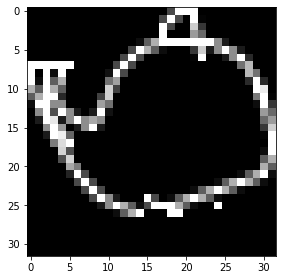

In [31]:
from skimage import io

io.imshow(sketches_flat[2600].reshape((out_size, out_size)))

## Filter Data

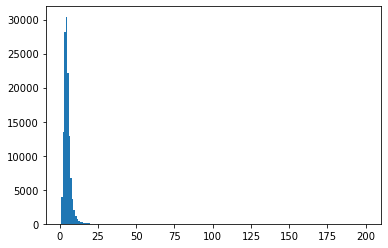

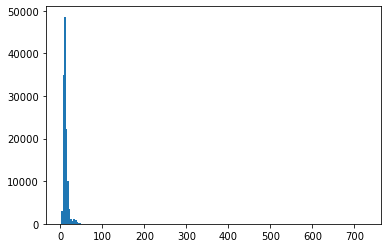

In [32]:
from functools import reduce
import matplotlib.pyplot as plt

stroke_stats = np.zeros((sketches_flat.shape[0], 2))

for i, drawing in enumerate(data):
    # Number of strokes
    stroke_stats[i, 0] = len(drawing['drawing'])
    # Length of strokes
    stroke_stats[i, 1] = reduce(lambda a, b: a + len(b[0]), drawing['drawing'], 0) / len(drawing['drawing'])
    
plt.hist(stroke_stats[:, 0], bins=200)
plt.show()

plt.hist(stroke_stats[:, 1], bins=200)
plt.show()

num_stroke_lower_end = np.percentile(stroke_stats[:,0], num_stroke_percentile_cutoff[0])
num_stroke_upper_end = np.percentile(stroke_stats[:,0], num_stroke_percentile_cutoff[1])
stroke_len_lower_end = np.percentile(stroke_stats[:,1], stroke_len_percentile_cutoff[0])
stroke_len_upper_end = np.percentile(stroke_stats[:,1], stroke_len_percentile_cutoff[1])

In [33]:
preselection = np.logical_and(
    np.logical_and(stroke_stats[:,0] > num_stroke_lower_end, stroke_stats[:,0] < num_stroke_upper_end),
    np.logical_and(stroke_stats[:,1] > stroke_len_lower_end, stroke_stats[:,1] < stroke_len_upper_end)
)

sketches_selected = sketches_flat[preselection]

print(f'Preselected {preselection.sum()} out of {stroke_stats.shape[0]}')

Preselected 119631 out of 126804


## Save images to file

Only for offline image similarity comparison

In [9]:
# import pathlib
# pathlib.Path(f'data/google-quickdraw/{name}').mkdir(parents=True, exist_ok=True)

# for i, sketch in enumerate(sketches_selected):
#     img = sketch.reshape((out_size, out_size)) * 255
#     io.imsave(f'data/google-quickdraw/{name}/{i}.png', img.astype(np.uint8))

## Compute Perceptual Distance Matrix

In [ ]:
# from itertools import combinations
# from perceptual import Metric

# m = Metric()

# c = combinations(range(sketches_selected.shape[0]), 2)
# len(list(c))

## Embed Drawings

In [34]:
from umap import UMAP

embeddings = UMAP(n_neighbors=5).fit_transform(sketches_flat)

/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pilingjs/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


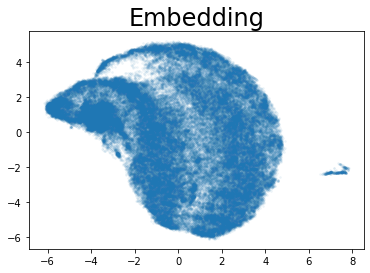

In [35]:
import matplotlib.pyplot as plt

plt.scatter(embeddings[:,0], embeddings[:,1], s=3, alpha=0.05)
plt.title('Embedding', fontsize=24);

## Scale Embeddings

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0.05, 0.95))
scaled_embeddings = scaler.fit_transform(embeddings)

In [37]:
from functools import reduce
import pycountry

# x, y, recognized, countrycode, num_strokes, mean_stroke_length
features = np.zeros((embeddings.shape[0], 6))

features[:, 0:2] = embeddings # x, y

for i, drawing in enumerate(data):
    features[i, 2] = drawing['recognized']
    try:
        features[i, 3] = pycountry.countries.get(alpha_2=drawing['countrycode']).numeric
    except AttributeError:
        features[i, 3] = 0
    features[i, 4] = len(drawing['drawing'])
    features[i, 5] = reduce(lambda a, b: a + len(b[0]), drawing['drawing'], 0) / len(drawing['drawing'])
    
features = features[preselection]

In [38]:
from sklearn.preprocessing import MinMaxScaler

features_scaled = MinMaxScaler().fit_transform(features)

## Sub-Sample Drawings

In [39]:
from apricot import FeatureBasedSelection

selector = FeatureBasedSelection(2000, concave_func='sqrt', optimizer='two-stage', n_jobs=-1, verbose=False)
_, selection = selector.fit_transform(features_scaled, np.arange(features_scaled.shape[0]))

## Save Data

In [40]:
import json 

with open('data/country-iso2-to-region.json', 'r') as f:
    country_to_region = json.load(f)

In [41]:
import codecs 

out = []

for i in selection:
    try:
        region = country_to_region[data[i]['countrycode']]
    except KeyError:
        region = None
        
    out.append({
        'countryCode': data[i]['countrycode'],
        'region': region,
        'recognized': data[i]['recognized'],
        'umapEmbedding': features_scaled[i, 0:2].tolist(),
        'src': np.array(data[i]['drawing']).tolist(),
    })

f = codecs.open(f'{data_dir}/_{name}.json', 'w', encoding='utf-8')
json.dump(out, f, separators=(',', ':'), sort_keys=True, indent=2)